In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from mediapipe_handcrop import MediapipeHandCrop
import os
import cv2
from PIL import Image
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


## New Test Dataset

In [4]:
transform = transforms.Compose([
    MediapipeHandCrop(max_num_hands=1, min_detection_confidence=0.5),  
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Create DataFrame for new test dataset

In [12]:
import os
import pandas as pd

# Directory containing the dataset
ROOT_DIR = "./asl_test_dataset"

data = []

for label in os.listdir(ROOT_DIR):
    label_dir = os.path.join(ROOT_DIR, label)
    
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            data.append({"file_path": file_path, "file_name": file_name, "label": label})

# Create a DataFrame
test_df = pd.DataFrame(data)

# Save DataFrame to CSV
CSV_FILE = "./asl_test_dataset/asl_dataset_csv.csv"
test_df.to_csv(CSV_FILE, index=False)

print(f"CSV file saved at {CSV_FILE}")


CSV file saved at ./asl_test_dataset/asl_dataset_csv.csv


In [13]:
df = pd.read_csv(CSV_FILE)
df.head()

,file_path,file_name,label
0,./asl_test_dataset\A\a.png,a.png,A
1,./asl_test_dataset\A\a1.png,a1.png,A
2,./asl_test_dataset\A\a2.png,a2.png,A
3,./asl_test_dataset\A\a3.png,a3.png,A
4,./asl_test_dataset\A\Pasted image (2).png,Pasted image (2).png,A


In [14]:
class NewTestDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.csv_file = csv_file
        self.df = pd.read_csv(self.csv_file)
        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, class_name))])

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if os.path.isdir(os.path.join(self.root_dir, class_name))}

    def __len__(self):
        # Zsumuj liczbę plików w podkatalogach
        dataset_len = sum(
            len(os.listdir(os.path.join(self.root_dir, class_)))
            for class_ in self.classes
            if os.path.isdir(os.path.join(self.root_dir, class_))
        )
        return dataset_len
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of bounds")
        
        image_path = self.df.loc[idx, "file_path"]
        
        # Debuging label
        # label = os.path.join(self.root_dir,
        #                      self.df.loc[idx, 'label'])
        label = self.class_to_idx[self.df.loc[idx, 'label']]
                                                     
         # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
    

In [15]:
# Train dataset and dataloader initialization
new_test_dataset = NewTestDataset(root_dir=ROOT_DIR, 
                        csv_file=CSV_FILE, 
                        transform=transform,
                        )

## Sanity check

Dataset len:
213

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


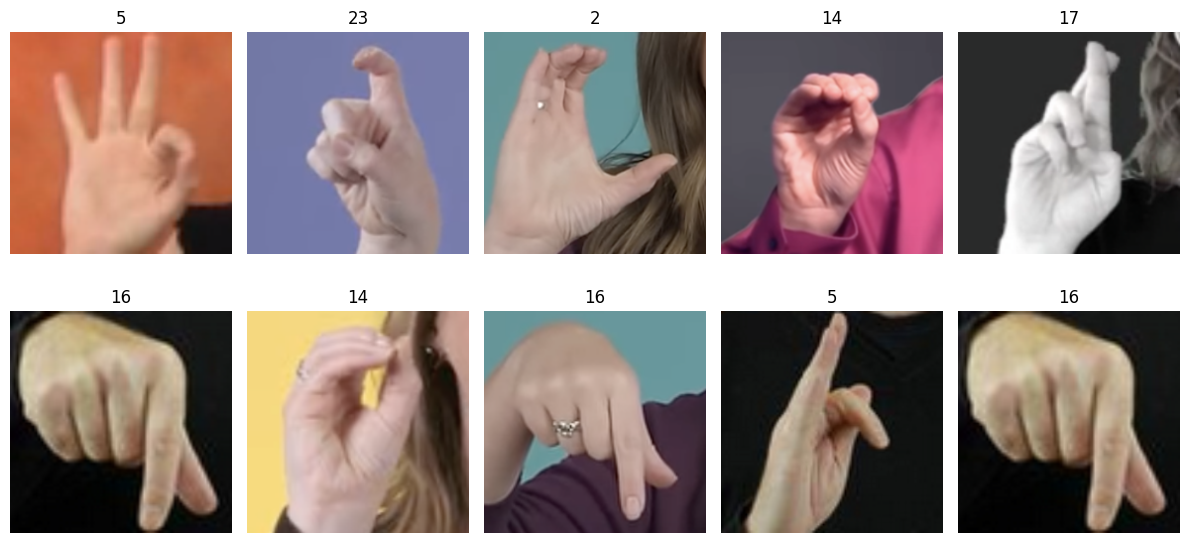

In [27]:
# Sanity check
print("Dataset len:")
print(len(new_test_dataset))

print("\nDataset classes:")
print(new_test_dataset.classes)

print("\nRandom images from dataset:")

plt.figure(figsize=(12,6))
for i in range(10):
    # Fetch image
    img, label = new_test_dataset[random.randint(0, len(new_test_dataset)-1)]
    image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

    # Denormalizing (there was normalization in transform)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * std + mean
    image = image.clip(0, 1)

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(label)

plt.tight_layout()
plt.show()

In [18]:
def predict_image(img, model, device, class_names):

    # image = img.convert('RGB')  # Konwersja na RGB
    image_tensor = img.unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class


In [19]:
def visualize_model_predictions(model, test_dataset):
    plt.figure(figsize=(12,6))
    for i in range(10):
        # Fetch image
        img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
        image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        class_names = test_dataset.classes

        # Denormalizing (there was normalization in transform)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = image * std + mean
        image = image.clip(0, 1)

        # Predicting image class with loaded model
        model.to()
        y_pred = predict_image(img, model, device, class_names)

        label_name = class_names[label]

        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"class: {label_name}\n predicted class: {y_pred}")

    plt.tight_layout()
    plt.show()

## Loading ResNet model

In [30]:
resnet_model = torch.load(f="./models/Resnet50_test1_model", weights_only=False)
resnet_model.to(device)
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

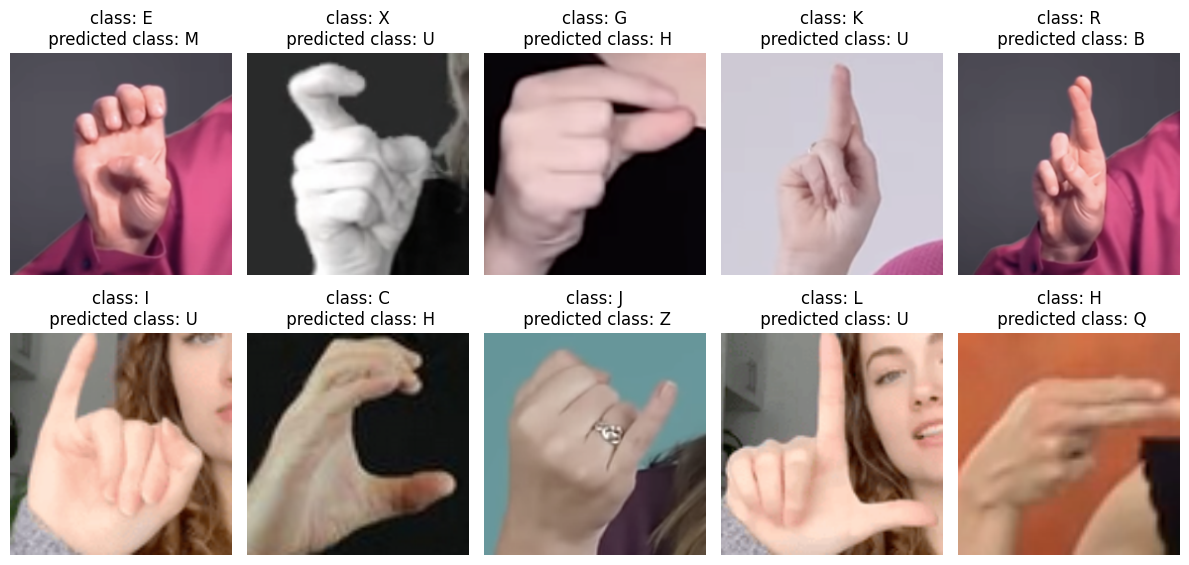

In [31]:
visualize_model_predictions(model=resnet_model,
                            test_dataset=new_test_dataset)

In [32]:
# Test loop
def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

In [33]:
test_dataloader = DataLoader(new_test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)

In [34]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(device, resnet_model, test_dataloader, criterion)

Test Loss: 0.1143, Test Accuracy: 13.15%


## Loading MobileNet model

In [35]:
mobilenet_model = torch.load(f="./models/MobileNet_test1_model", weights_only=False)
mobilenet_model.to(device)
print(mobilenet_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

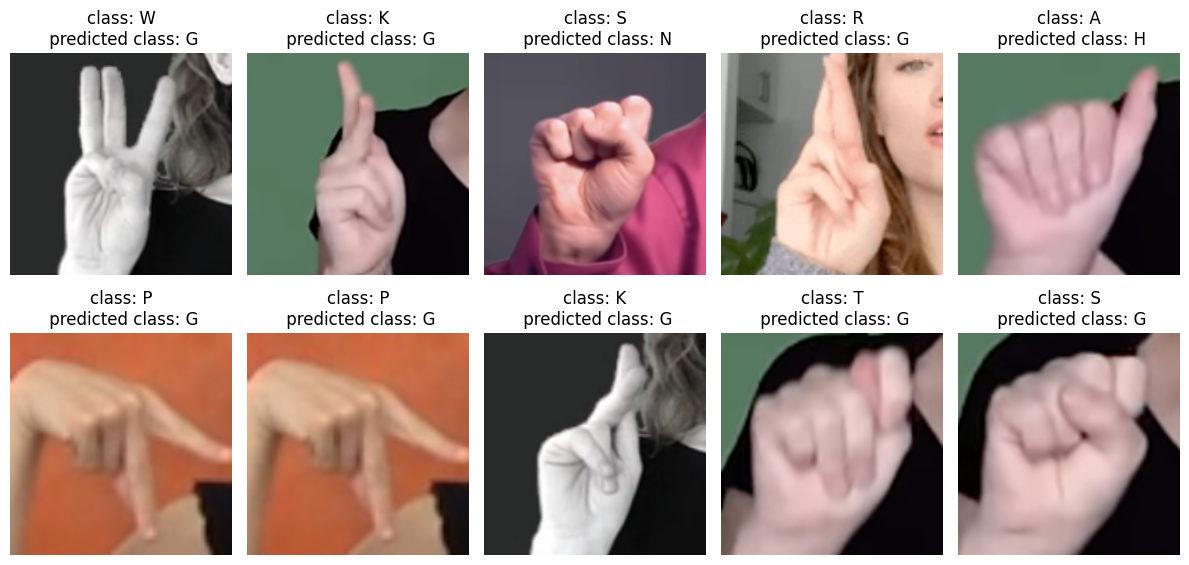

In [36]:
visualize_model_predictions(model=mobilenet_model,
                            test_dataset=new_test_dataset)

In [37]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(device, mobilenet_model, test_dataloader, criterion)

Test Loss: 0.1439, Test Accuracy: 7.51%


## Loading Custom CNN model

In [39]:
import torch
from CustomCNN import CustomCNN  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model architecture
custom_CNN_model = CustomCNN(num_classes=26)

# Load weights
custom_CNN_model.load_state_dict(torch.load("./models/Custom_CNN_test1_weights"))

# Move to device
custom_CNN_model.to(device)

# Print the model architecture
print(custom_CNN_model)


NameError: name 'CustomCNN2' is not defined

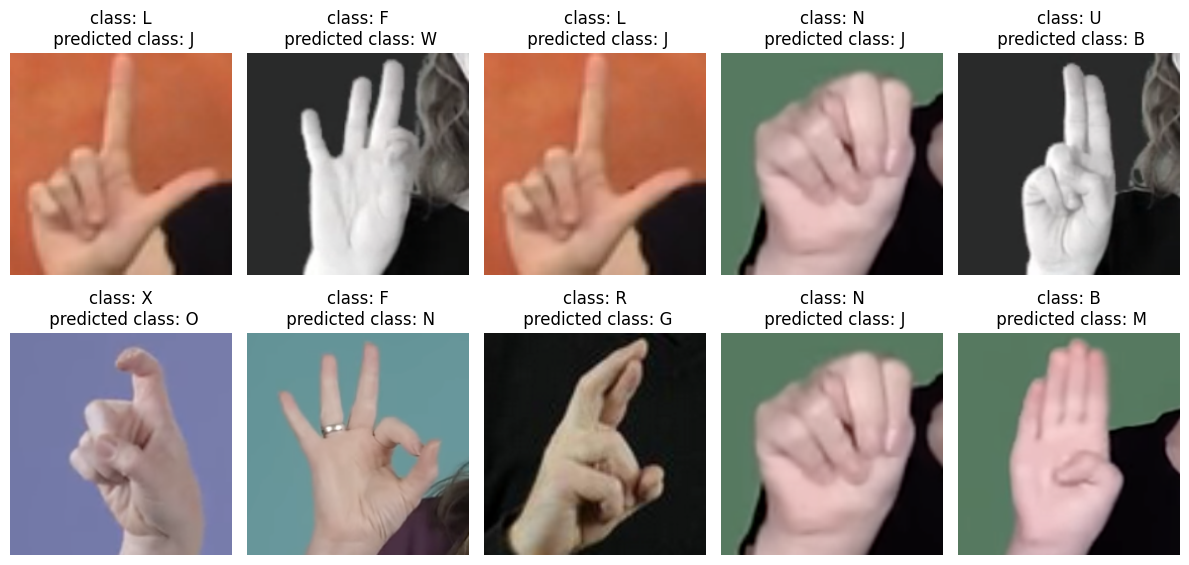

In [29]:
visualize_model_predictions(model=custom_CNN_model,
                            test_dataset=new_test_dataset)

In [30]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(device, custom_CNN_model, test_dataloader, criterion)

Test Loss: 1.0475, Test Accuracy: 3.76%


## SECOND CNN - 1 epoch

In [40]:
import torch
from CustomCNN import CustomCNN2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model architecture
custom_CNN_model = CustomCNN2(num_classes=26)

# Load weights
custom_CNN_model.load_state_dict(torch.load("./models/Custom_CNN_test1_weights"))

# Move to device
custom_CNN_model.to(device)

# Print the model architecture
print(custom_CNN_model)


C:\Users\Hyperbook\AppData\Local\Temp\ipykernel_14624\534574809.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_CNN_model.load_state_dict(torch.load("./models/Cu

CustomCNN2(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=26, bias=True)
  )
)


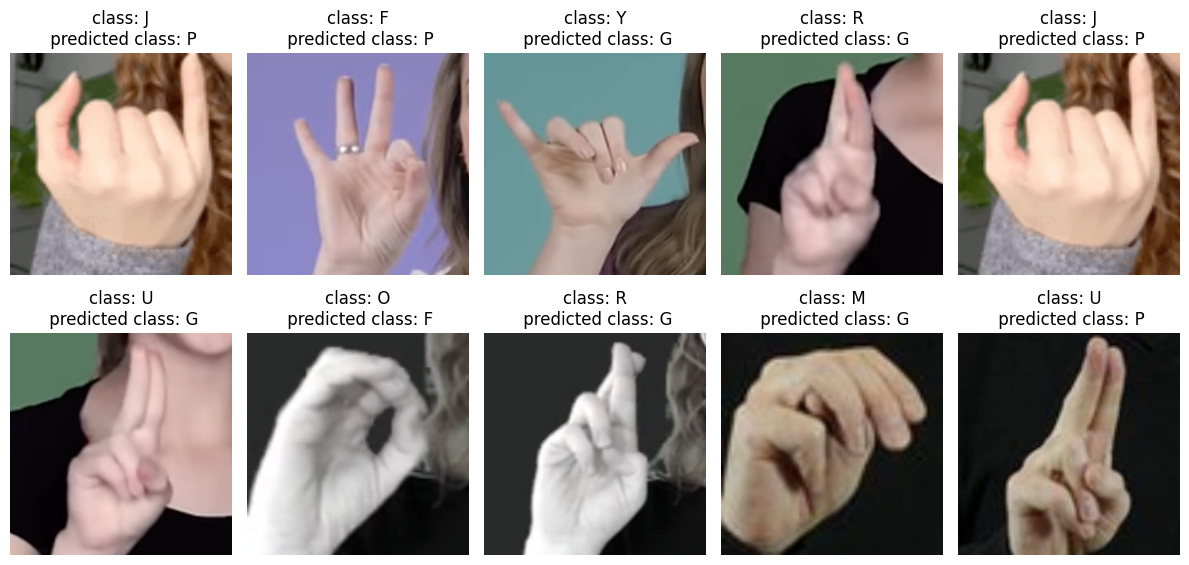

In [41]:
visualize_model_predictions(model=custom_CNN_model,
                            test_dataset=new_test_dataset)

In [42]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(device, custom_CNN_model, test_dataloader, criterion)

Test Loss: 0.4591, Test Accuracy: 4.69%


## IMAGENET TRAINED ON NEW DATASET

In [1]:
mobilenet_model = torch.load(f="./models/New vaidated dataset MobileNet model, epoch 2", weights_only=False)
mobilenet_model.to(device)
print(mobilenet_model)


NameError: name 'torch' is not defined

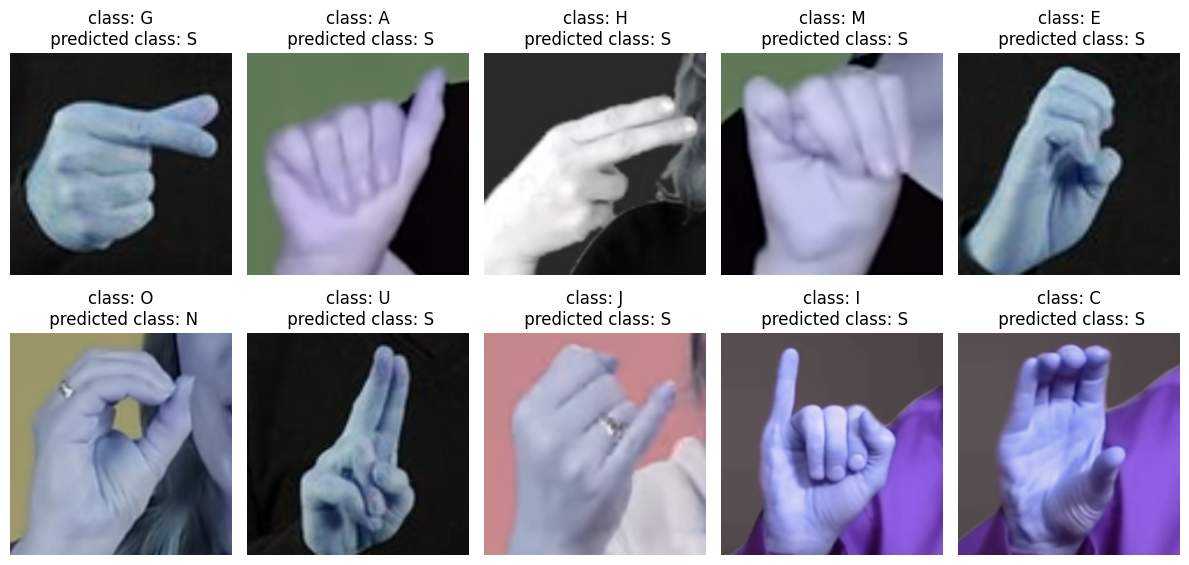

In [22]:
visualize_model_predictions(model=mobilenet_model,
                            test_dataset=new_test_dataset)